### Example 10: Poisson / Negative Binomial Rate Change

### 2.1 What to do?
In this example we compare event **counts** across multiple time-points for the same observational
units (e.g. hospital departments over four years) using `statsmed.poisson_negbin_rate_change()`.

Steps:
- Load `ex10.csv` (80 units, 4 years: 2019–2022, readmission counts + discharges as exposure).
- **Categorical analysis**: Rate Ratios for each year vs. the reference year 2019.
- **Trend analysis**: A single Rate Ratio per year (linear trend).
- **Two-timepoint subset**: Using only 2 entries in `timepoints` for a simple before/after comparison.
- **Overdispersion check** and **Negative Binomial** sensitivity analysis.
- **`report_rr()`** as a standalone helper.

Notes:
- The data is synthetic; the simulated effect is a ~10% rate decrease per year.
- `exposure_col='discharges'` provides an offset so the model estimates rates (events/discharges)
  rather than raw counts.
- Cluster-robust SE accounts for within-unit correlation across time-points.

    unit_id  year  readmissions  discharges
0         1  2019            12         172
1         1  2020             7         154
2         1  2021             2         100
3         1  2022             7         168
4         2  2019            11         143
5         2  2020            10         214
6         2  2021            20         211
7         2  2022             1          88
8         3  2019             2          87
9         3  2020             7         183
10        3  2021             8          93
11        3  2022             3         203

Shape: (320, 4)
Unique units: 80
Years: [2019, 2020, 2021, 2022]


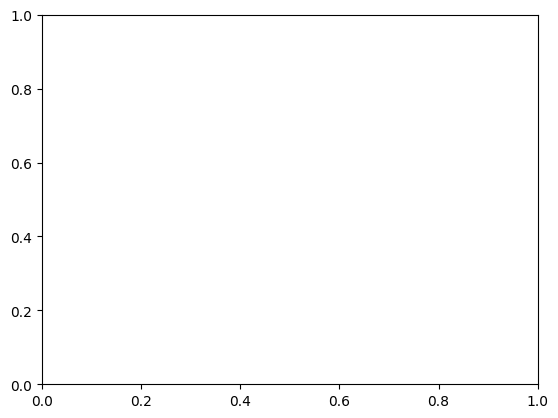

In [1]:
import pandas as pd
import numpy as np
from statsmed import statsmed

# Load data
df = pd.read_csv('ex10.csv')
print(df.head(12))
print(f"\nShape: {df.shape}")
print(f"Unique units: {df['unit_id'].nunique()}")
print(f"Years: {sorted(df['year'].unique().tolist())}")

In [2]:
# --- Step 1: Categorical -- each year vs. reference 2019 (Poisson) ---
rr_cat, fit_cat = statsmed.poisson_negbin_rate_change(
    df,
    id_col='unit_id',
    time_col='year',
    count_col='readmissions',
    timepoints=['2019', '2020', '2021', '2022'],   # first = reference
    time_as='categorical',
    exposure_col='discharges',
    model='poisson',
    cluster_se=True,
    quiet=False,
)
print('\nReturned dict:')
for k, v in rr_cat.items():
    print(f'  {k}: {v}')

=== Poisson rate change (categorical, ref = 2019) ===
  2020 vs 2019:  RR = 0.914  (95% CI 0.831 – 1.004); p = 0.06
  2021 vs 2019:  RR = 0.833  (95% CI 0.748 – 0.927); p < 0.001
  2022 vs 2019:  RR = 0.734  (95% CI 0.662 – 0.815); p < 0.001
Offset/Exposure: discharges
Fixed effects: False, Cluster SE: True

Returned dict:
  2020: {'RR': 0.914, 'CI_low': 0.831, 'CI_high': 1.004, 'p': 0.05987955848488049}
  2021: {'RR': 0.833, 'CI_low': 0.748, 'CI_high': 0.927, 'p': 0.0008496851425971626}
  2022: {'RR': 0.734, 'CI_low': 0.662, 'CI_high': 0.815, 'p': 6.7585527096494564e-09}
  _meta: {'model': 'poisson', 'fixed_effects': False, 'cluster_se': True, 'reference': np.int64(2019)}


In [3]:
# --- Step 2: Trend -- single RR per year (Poisson) ---
rr_trend, fit_trend = statsmed.poisson_negbin_rate_change(
    df,
    id_col='unit_id',
    time_col='year',
    count_col='readmissions',
    timepoints=['2019', '2020', '2021', '2022'],
    time_as='trend',
    exposure_col='discharges',
    model='poisson',
    cluster_se=True,
    quiet=False,
)
print('\nReturned dict:', rr_trend)

=== Poisson rate change (trend) ===
  RR per time-unit = 0.904  (95% CI 0.874 – 0.935); p < 0.001
  Time-units: ['2019', '2020', '2021', '2022'] -> [0, 1, 2, 3]
  Offset/Exposure: discharges
  Fixed effects: False, Cluster SE: True

Returned dict: {'RR': 0.904, 'CI_low': 0.874, 'CI_high': 0.935, 'p': 3.0234478679786102e-09, 'model': 'poisson', 'fixed_effects': False, 'cluster_se': True}


In [4]:
# --- Step 3: Two-timepoint subset (2019 vs 2022 only) ---
rr_2tp, fit_2tp = statsmed.poisson_negbin_rate_change(
    df,
    id_col='unit_id',
    time_col='year',
    count_col='readmissions',
    timepoints=['2019', '2022'],   # just two timepoints
    time_as='categorical',
    exposure_col='discharges',
    model='poisson',
    cluster_se=True,
    quiet=False,
)
print('\nReturned dict:', rr_2tp)

=== Poisson rate change (categorical, ref = 2019) ===
  2022 vs 2019:  RR = 0.734  (95% CI 0.662 – 0.815); p < 0.001
Offset/Exposure: discharges
Fixed effects: False, Cluster SE: True

Returned dict: {'2022': {'RR': 0.734, 'CI_low': 0.662, 'CI_high': 0.815, 'p': 6.401201468780459e-09}, '_meta': {'model': 'poisson', 'fixed_effects': False, 'cluster_se': True, 'reference': np.int64(2019)}}


In [5]:
# --- Step 4: Overdispersion check ---
disp = statsmed.quick_overdispersion_check_poisson(fit_cat)
print(f"Pearson chi2 / df_resid = {disp:.3f}")
if disp > 1.5:
    print("  -> Overdispersion detected. Consider Negative Binomial or quasi-Poisson.")
else:
    print("  -> No strong overdispersion. Poisson model is adequate.")

Pearson chi2 / df_resid = 2.292
  -> Overdispersion detected. Consider Negative Binomial or quasi-Poisson.


In [6]:
# --- Step 5: Negative Binomial -- categorical (sensitivity analysis) ---
rr_nb, fit_nb = statsmed.poisson_negbin_rate_change(
    df,
    id_col='unit_id',
    time_col='year',
    count_col='readmissions',
    timepoints=['2019', '2020', '2021', '2022'],
    time_as='categorical',
    exposure_col='discharges',
    model='negbin',
    cluster_se=True,
    quiet=False,
)
print('\nReturned dict:')
for k, v in rr_nb.items():
    print(f'  {k}: {v}')

=== Negative Binomial (NB2) rate change (categorical, ref = 2019) ===
  2020 vs 2019:  RR = 0.907  (95% CI 0.829 – 0.992); p = 0.033
  2021 vs 2019:  RR = 0.826  (95% CI 0.744 – 0.916); p < 0.001
  2022 vs 2019:  RR = 0.737  (95% CI 0.668 – 0.814); p < 0.001
Offset/Exposure: discharges
Fixed effects: False, Cluster SE: True

Returned dict:
  2020: {'RR': 0.907, 'CI_low': 0.829, 'CI_high': 0.992, 'p': 0.03337056162364925}
  2021: {'RR': 0.826, 'CI_low': 0.744, 'CI_high': 0.916, 'p': 0.00031261839310313475}
  2022: {'RR': 0.737, 'CI_low': 0.668, 'CI_high': 0.814, 'p': 1.8701329295517922e-09}
  _meta: {'model': 'negative_binomial_nb2', 'fixed_effects': False, 'cluster_se': True, 'reference': np.int64(2019)}


In [7]:
# --- Step 6: report_rr() standalone on any fitted model ---
# Extract the RR for a specific term from any statsmodels result
rr_manual = statsmed.report_rr(fit_trend, '_time_num', N_of_decimals=4)
print('report_rr() output:', rr_manual)

report_rr() output: {'RR': 0.9038, 'CI_low': 0.874, 'CI_high': 0.9345, 'p': 3.0234478679786102e-09}


We compared readmission rates across four years using Poisson and Negative Binomial regression
with cluster-robust standard errors and an exposure offset.

- **Categorical** analysis showed decreasing Rate Ratios for each subsequent year relative to 2019.
- **Trend** analysis yielded a single per-year RR, summarizing the monotonic decline.
- A simple **two-timepoint** comparison (2019 vs 2022) is achieved by passing only two elements in `timepoints`.
- `report_rr()` can be used standalone to extract Rate Ratios from any statsmodels regression result.

### 2.2 What to write?

- In Methods (categorical): "We modeled the change in readmission counts across four years
  using Poisson regression with treatment-coded dummy variables (reference: 2019), a log-offset
  for the number of discharged patients, and cluster-robust standard errors at the unit level.
  Exponentiated coefficients were interpreted as Rate Ratios (RR) with 95% Wald confidence
  intervals."
- In Methods (trend): "To test for a monotonic trend, we entered year as an ordinal predictor
  (0, 1, 2, 3) in a Poisson log-linear model with cluster-robust SE and exposure offset.
  The exponentiated coefficient represents the multiplicative change in rate per year."
- In a sensitivity analysis: "As a sensitivity analysis, we repeated the analysis using a
  Negative Binomial (NB2) model to account for potential overdispersion."
- In Results: "Readmission rates declined over the study period (trend RR = X.XX per year,
  95% CI X.XX–X.XX; p = X.XXX). Compared to 2019, rates in 2022 were reduced by approximately
  XX% (RR = X.XX, 95% CI X.XX–X.XX; p = X.XXX)."